<a href="https://colab.research.google.com/github/anadiedrichs/2023-nlp-tps/blob/main/3b_Custom_embedding_con_Gensim_ingredientes_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural

### Datos de la alumna:

Ana Laura Diedrichs

SIU a0902


## Custom embedddings con Gensim

### Uso de dataset de recetas de cocina

Procedo a descargar un dataset de recetas de cocina, que además lista sus ingredientes desde Kaggle:

https://www.kaggle.com/datasets/nazmussakibrupol/3a2m-cooking-recipe-dataset


In [1]:
# Descargar la carpeta de dataset
import os
import platform
url = "https://www.dropbox.com/scl/fi/j4mqu2e9a8ywcnaft5fjo/3a2m-cooking.zip?rlkey=u6ntt0n47b16dlxhvvdxks6lc&dl=1"
if os.access('./3a2m-cooking', os.F_OK) is False:
    if os.access('3a2m-cooking.zip', os.F_OK) is False:
      !wget -O 3a2m-cooking.zip https://www.dropbox.com/scl/fi/j4mqu2e9a8ywcnaft5fjo/3a2m-cooking.zip?rlkey=u6ntt0n47b16dlxhvvdxks6lc&dl=1
    !unzip -q 3a2m-cooking.zip
else:
    print("El dataset ya se encuentra descargado")

--2023-08-28 15:09:46--  https://www.dropbox.com/scl/fi/j4mqu2e9a8ywcnaft5fjo/3a2m-cooking.zip?rlkey=u6ntt0n47b16dlxhvvdxks6lc
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/j4mqu2e9a8ywcnaft5fjo/3a2m-cooking.zip?rlkey=u6ntt0n47b16dlxhvvdxks6lc [following]
--2023-08-28 15:09:46--  https://www.dropbox.com/e/scl/fi/j4mqu2e9a8ywcnaft5fjo/3a2m-cooking.zip?rlkey=u6ntt0n47b16dlxhvvdxks6lc
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc15306c07432ce4863140e641fa.dl.dropboxusercontent.com/cd/0/inline/CCrcliGEM21FBwUEE4K4NPMawnMFfWSecAr-iWePtOrpk36FK0FtTb4REZaRlT29cXPDqKyOapxu6uyeyhP_nlrmemnGpzh4LenVrKKsQQ10l-Ha6FPXrGqZ2J0L_hJxsWM/file# [following]
--2023-08-28 15:09:47--  https://uc15306c07432ce4863140e641fa.d

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

### Datos
Utilizaremos como dataset canciones de bandas de habla inglesa.

In [3]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2023-08-28 15:10:14--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2023-08-28 15:10:14--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2023-08-28 15:10:15--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (

In [4]:
!ls -la

total 1966784
drwxr-xr-x 1 root root       4096 Aug 28 15:10 .
drwxr-xr-x 1 root root       4096 Aug 28 15:08 ..
-rw-r--r-- 1 root root  470582689 Aug 28 15:09 3a2m-cooking.zip
-rw-r--r-- 1 root root 1541295067 Jul 26  2022 3A2M.csv
drwxr-xr-x 4 root root       4096 Aug 24 21:24 .config
drwxr-xr-x 1 root root       4096 Aug 24 21:25 sample_data
drwxr-xr-x 2 root root       4096 Aug 19  2020 songs_dataset
-rw-r--r-- 1 root root    2075036 Aug 28 15:10 songs_dataset.zip


In [5]:
! head 3A2M.csv

,title,directions,NER,genre,label
0,Reeses Cups(Candy)  ,"[""Combine first four ingredients and press in 13 x 9-inch ungreased pan."", ""Melt chocolate chips and spread over mixture. Refrigerate for about 20 minutes and cut into pieces before chocolate gets hard."", ""Keep in refrigerator.""]","[""peanut butter"", ""graham cracker crumbs"", ""butter"", ""powdered sugar"", ""chocolate chips""]",drinks,2
1,Rhubarb Coffee Cake,"[""Cream sugar and butter."", ""Add egg and beat well."", ""To creamed butter, sugar and egg, add alternately buttermilk with mixture of flour, salt and soda."", ""Mix well."", ""Add rhubarb and vanilla."", ""Pour into greased 9 x 13-inch pan and add Topping.""]","[""sugar"", ""butter"", ""egg"", ""buttermilk"", ""flour"", ""salt"", ""soda"", ""buttermilk"", ""rhubarb"", ""vanilla""]",drinks,2
2,Quick Barbecue Wings,"[""Clean wings."", ""Flour and fry until done."", ""Place fried chicken wings in microwave bowl."", ""Stir in barbecue sauce."", ""Microwave on High (

In [6]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('3A2M.csv')
df.head()

,Unnamed: 0,title,directions,NER,genre,label
0,0,Reeses Cups(Candy),"[""Combine first four ingredients and press in ...","[""peanut butter"", ""graham cracker crumbs"", ""bu...",drinks,2
1,1,Rhubarb Coffee Cake,"[""Cream sugar and butter."", ""Add egg and beat ...","[""sugar"", ""butter"", ""egg"", ""buttermilk"", ""flou...",drinks,2
2,2,Quick Barbecue Wings,"[""Clean wings."", ""Flour and fry until done."", ...","[""chicken"", ""flour"", ""barbecue sauce""]",nonveg,3
3,3,Chocolate Frango Mints,"[""Mix ingredients together for 5 minutes."", ""S...","[""cake mix"", ""chocolate fudge pudding"", ""sour ...",drinks,2
4,4,Corral Barbecued Beef Steak Strips,"[""Brown strips in cooking oil."", ""Pour off dri...","[""long"", ""cooking oil"", ""tomato sauce"", ""water...",drinks,2


In [7]:
df = pd.DataFrame(df["NER"])
df.head()

,NER
0,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
1,"[""sugar"", ""butter"", ""egg"", ""buttermilk"", ""flou..."
2,"[""chicken"", ""flour"", ""barbecue sauce""]"
3,"[""cake mix"", ""chocolate fudge pudding"", ""sour ..."
4,"[""long"", ""cooking oil"", ""tomato sauce"", ""water..."


In [8]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2231143


### 1 - Preprocesamiento

In [9]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [10]:
# Demos un vistazo
sentence_tokens[:2]

[['peanut',
  'butter',
  'graham',
  'cracker',
  'crumbs',
  'butter',
  'powdered',
  'sugar',
  'chocolate',
  'chips'],
 ['sugar',
  'butter',
  'egg',
  'buttermilk',
  'flour',
  'salt',
  'soda',
  'buttermilk',
  'rhubarb',
  'vanilla']]

### 2 - Crear los vectores (word2vec)

In [11]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [12]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [13]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [14]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 2231143


In [15]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 9114


### 3 - Entrenar el modelo generador

Entrené únicamente con 4 (cuatro) epochs para que no demore mucho el notebook en correr.

In [16]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=4,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 77676384.0
Loss after epoch 1: 28406352.0
Loss after epoch 2: 26860144.0
Loss after epoch 3: 1274848.0


(72318433, 114945404)

### 4 - Ensayar

In [17]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["flour"], topn=10)

[('flor', 0.6548495292663574),
 ('snowdrift', 0.6512137651443481),
 ('spry', 0.632708728313446),
 ('bakin', 0.6160374283790588),
 ('ufb02our', 0.615901529788971),
 ('soad', 0.615530252456665),
 ('floor', 0.613299548625946),
 ('criso', 0.6122484803199768),
 ('nonhydrogenated', 0.6117061972618103),
 ('sat', 0.6086899638175964)]

Observamos que dentro de la distancia similar positiva encontramos palabras similares a harina (flour) como flor o floor o con caracteres como ufb02our. Se requiere un mejor preprocesamiento del dataset

In [18]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["bread"], topn=10)

[('color', 0.01936226151883602),
 ('glycerin', 0.019261756911873817),
 ('essential', 0.015264417976140976),
 ('licorice', 0.0020710360258817673),
 ('soap', -0.0023513620253652334),
 ('sherbet', -0.005559819750487804),
 ('coloring', -0.006362671498209238),
 ('vera', -0.006941539701074362),
 ('stick', -0.013835484161973),
 ('tamarind', -0.015031631104648113)]

Arriba observamos las palabras que menos se relacionan con bread (pan) según la representación del modelo w2v. Entre ellas por ejemplo glicerina, jabón.

In [19]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["cheese"], topn=10)

[('chesse', 0.6973788142204285),
 ('cheeese', 0.6714235544204712),
 ('chese', 0.632571816444397),
 ('packagesshredded', 0.6317858695983887),
 ('chees', 0.6312068104743958),
 ('motzerella', 0.6234297156333923),
 ('meunster', 0.6210774183273315),
 ('chz', 0.6178605556488037),
 ('fontinella', 0.6169974207878113),
 ('montery', 0.6169180274009705)]

Entre las palabras relacionadas con cheese (queso) hay varias formas de escribir o deletrear cheese. Nuevamente resalto el punto de que puede que el dataset de origen no se encuentra muy limpio y esto implicaría necesitar más preprocesamiento.

In [20]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["tomato"], topn=5)

[('tomatoe', 0.7164051532745361),
 ('contadina', 0.6733307242393494),
 ('spatini', 0.6684426665306091),
 ('tomoto', 0.6677120923995972),
 ('tomatoes', 0.6564962267875671)]

En el ejemplo anterior entre las palabras más relacionadas  con el vocablo tomato encontramos la palabra contadina que es una marca de salsa de tomate italiana.

### 5 - Visualizar agrupación de vectores

In [21]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model):
    num_dimensions = 2

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

# Graficar los embedddings en 2D

In [41]:
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


In [ ]:

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

In [42]:
MAX_WORDS=200
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

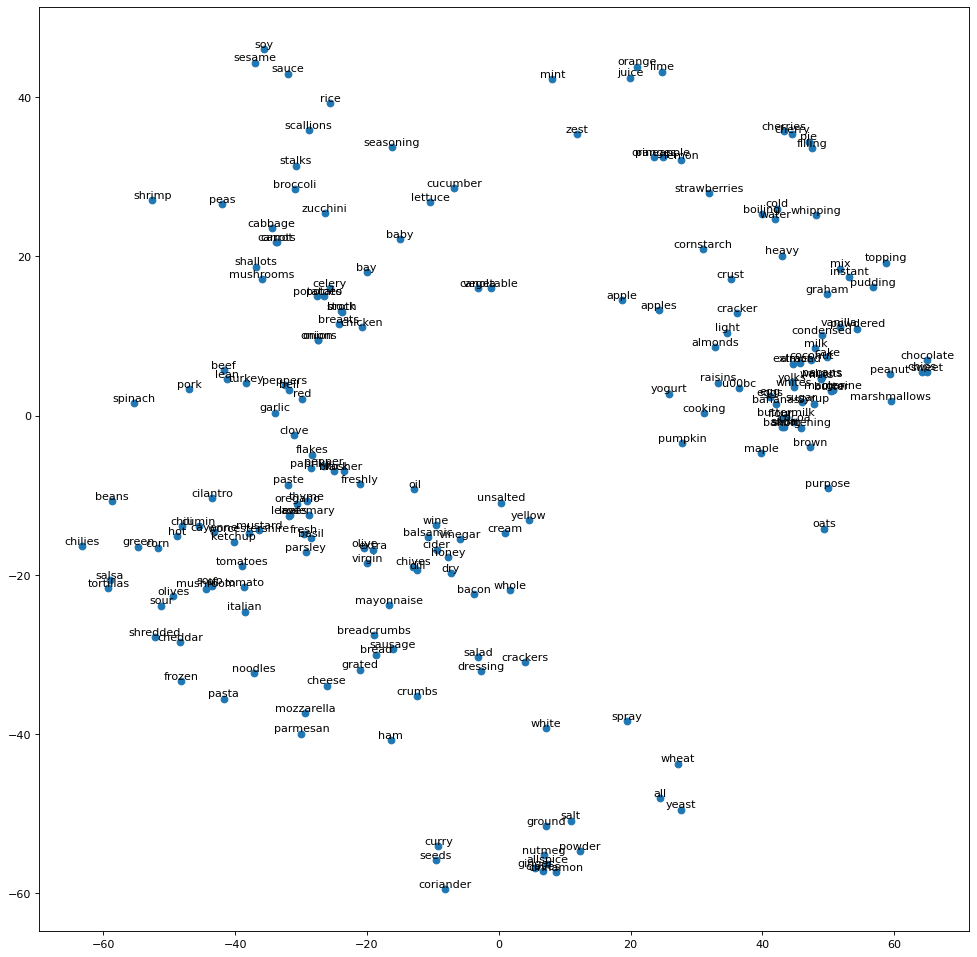

In [44]:
from matplotlib.pyplot import figure

figure(figsize=(15, 15), dpi=80)

import matplotlib.pyplot as plt

MAX_WORDS=200

x=x_vals[:MAX_WORDS]

y=y_vals[:MAX_WORDS]

text=labels[:MAX_WORDS]

plt.scatter(x,y )

# add labels to all points
for (xi, yi,t) in zip(x, y,text):
    plt.text(xi, yi, t, va='bottom', ha='center')


### Conclusiones

Del gráfico anterior de embeddings es muy interesante notar las diferentes agrupaciones.

* Wheat y yeast están muy cercanas (rango en Y (-60,-40) y rango en X (20,40)). Tanto el trigo y la levadura van de la mano para diferentes panificados.

* Muy cerca de cheese, punto (26,33), se encuentran los términos relacionados parmesan (tipo de queso), mozzarella (tipo de queso), grated (gratinado) y bread (pan).

* A la derecha y arriba del gráfico se agrupan términos relativos a comidas usadas en desayuno o dulces (avena, chocolate, frutas varias, jugos, toppings, etc)

* Previo a realizar a crear una representación en embeddings, notamos la importancia del pre-procesamiento del dataset. Pues se repiten varios términos similares pero con errores de tipeo que podrían quedar en uno solo, como observamos en el caso del tomate y el queso.